In [5]:
import os
import torch 
import pytorch_lightning as pl #pip install pytorch-lightning
from monai.networks.nets import UNet # pip install monai
from monai.losses import DiceLoss
from monai.data import CacheDataset, DataLoader
from monai.transforms import Compose, RandSpatialCrop, RandRotate90, ToTensor, Lambda 
import numpy as np
import nibabel as nib # pip install nibabel
import nrrd

In [8]:
# Version-1 

class AutoEncoder(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.unet = UNet(
            spatial_dims=3,
            in_channels=1,
            out_channels=2, #########################################
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2,
        )
        self.loss_function = DiceLoss(sigmoid=True, to_onehot_y=True)

    def forward(self, x):
        return self.unet(x)

    def training_step(self, batch, batch_idx):
        x, _ = batch
        x_hat = self.unet(x)
        loss = self.loss_function(x_hat, x)
        self.log('train_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

# Define dataset and data loader
data_dir = "./images"
transform = Compose([
    Lambda(func=lambda x: np.expand_dims(x, 0) if x.ndim == 3 else x),  # Add channel dimension if necessary
    RandSpatialCrop((256, 256, 256), random_size=False),
    RandRotate90(prob=0.5),
    ToTensor(dtype=torch.float32)
])
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.files = [f for f in os.listdir(data_dir) if f.endswith('.nrrd')]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = os.path.join(self.data_dir, self.files[idx])
        
        # Use pynrrd to load NRRD file
        data, header = nrrd.read(file_path)
        
        # Assuming data is already in the desired format (e.g., numpy array)
        if self.transform:
            data = self.transform(data)
        
        # Assuming target is the same as input for autoencoder
        return data, data


dataset = MyDataset(data_dir, transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0) #ADJUSTED NUM_WORKERS TO 0 and solved runtime error

# Define Lightning trainer
trainer = pl.Trainer(
    max_epochs=100,
    #callbacks=[pl.callbacks.EarlyStopping(monitor='train_loss')], ##################################
    profiler='simple'
)


# Initialize model and start training
model = AutoEncoder()
trainer.fit(model, dataloader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type     | Params
-------------------------------------------
0 | unet          | UNet     | 4.8 M 
1 | loss_function | DiceLoss | 0     
-------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.226    Total estimated model params size (MB)


Epoch 99: 100%|██████████| 1/1 [00:01<00:00,  0.57it/s, v_num=3]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 1/1 [00:02<00:00,  0.47it/s, v_num=3]

FIT Profiler Report

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                        	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                                                                                                         	|  -              	|  4929           	|

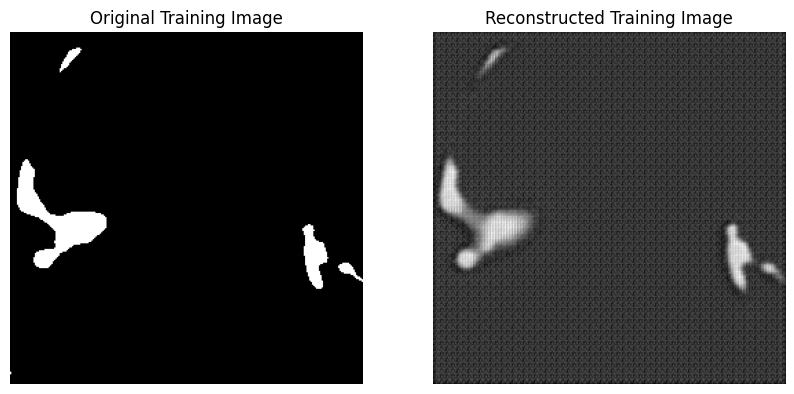

In [16]:
import matplotlib.pyplot as plt


# Set the model to evaluation mode
model.eval()

# Pass the original data through the model to get reconstructed images
reconstructed_images = []
original_images = []
for data, _ in dataloader:
    with torch.no_grad():
        reconstructed = model(data)
    reconstructed_images.append(reconstructed.cpu().numpy())
    original_images.append(data.cpu().numpy())

# Visualize original and reconstructed images
num_samples = len(reconstructed_images)
for i in range(num_samples):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original_images[i][0, 0, :, :, 256//2], cmap='gray')  
    axes[0].set_title('Original Training Image')
    axes[0].axis('off')
    axes[1].imshow(reconstructed_images[i][0, 0, :, :, 256//2], cmap='gray') 
    axes[1].set_title('Reconstructed Training Image')
    axes[1].axis('off')
    plt.show()
